In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
import numpy as np

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
trisoPkFrac = 0.3
pebblePkFrac = 0.64


erchPercent = range(5,21)
U_form = 1;
O_form = 2;
rho_fuel = 10.96; # g/cm3

trisoPartThicknesses = [253.5, 97.7, 41.9, 37.5, 45.6]; #um

coolTemp = 450+273.15 #C -> K
coolPres = 8 #MPa

In [3]:
#      Buffer
buffer = openmc.Material(name='Buffer')
buffer.set_density('g/cm3', 1.0)
buffer.add_element('C', 1.0)
#buffer.add_s_alpha_beta('c_Graphite')

#      IPyC
IPyC = openmc.Material(name='IPyC')
IPyC.set_density('g/cm3', 1.9)
IPyC.add_element('C', 1.0)
#IPyC.add_s_alpha_beta('c_Graphite')

#      SiC
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

#      OPyC
OPyC = openmc.Material(name='OPyC')
OPyC.set_density('g/cm3', 1.87)
OPyC.add_element('C', 1.0)
#OPyC.add_s_alpha_beta('c_Graphite')

# Moderator
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
#graphite.add_s_alpha_beta('c_Graphite')

# Coolant
He = openmc.Material(name='He')
He.set_density('g/cm3',coolPres/coolTemp/2.0771)
He.add_element('He',1.0)
He.temperature = coolTemp

# extra reflector material
water = openmc.Material()
water.set_density('g/cm3',1.05)
water.add_nuclide('H2',2.0)
water.add_element('O',1.0)
water.add_s_alpha_beta('c_D_in_D2O')

# alternative 
e_moderator = openmc.Material(name='LiOH')
e_moderator.set_density("g/cm3", 1.39)
e_moderator.add_nuclide('Li6', 0.00001251904, 'wo')
e_moderator.add_nuclide('Li7', 0.2929339,'wo')
e_moderator.add_nuclide('O16', 0.6657193, 'wo')
e_moderator.add_nuclide('O17', 0.0002688907, 'wo')
e_moderator.add_nuclide('H1',  0.04195279, 'wo')
e_moderator.add_nuclide('H2',  0.00001257524, 'wo')

# another alternative
beryl = openmc.Material(name='Beryllium')
beryl.set_density('g/cm3',1.85);
beryl.add_element('Be',1.0)
beryl.add_s_alpha_beta('c_Be')


In [4]:
#B5
trisoPartRads = trisoPartThicknesses
for i in range(1,5):
    trisoPartRads[i] += trisoPartRads[i-1]
trisoPartVolFracs = trisoPartRads
for i in range(5):
    trisoPartVolFracs[i] = (trisoPartRads[i]/trisoPartRads[4])**3
for i in range(4):
    trisoPartVolFracs[4-i] -= trisoPartVolFracs[3-i]
    


In [5]:
#B6
pebbleRads = [25, 30]
pebbleVolFracs = pebbleRads
for i in range(2):
    pebbleVolFracs[i] = (pebbleRads[i]/pebbleRads[1])**3
pebbleVolFracs[1] -= pebbleVolFracs[0]

In [6]:
#Enrichment Optimization
k_inf_erchPercent = []
kieP = []
for epi in erchPercent:
    #B4
    # TRISO Particles
    
    #      Fuel Kernel
    fuel = openmc.Material(name="fuel")
    fuel.set_density('g/cm3', rho_fuel)
    fuel.add_nuclide('U235',epi/100*U_form/(U_form+O_form))
    fuel.add_nuclide('U238',((1-epi/100)*U_form/(U_form+O_form)))
    fuel.add_element('O', O_form/(U_form+O_form))

    
    homogTrisoPart = openmc.Material.mix_materials([fuel, buffer, IPyC, SiC, OPyC], trisoPartVolFracs, 'vo')

    homogTrisoPebCore = openmc.Material.mix_materials([homogTrisoPart,graphite], [trisoPkFrac, 1-trisoPkFrac], 'vo');
    homogTrisoPebble = openmc.Material.mix_materials([homogTrisoPebCore, graphite], pebbleVolFracs, 'vo');


    #B7
    homogCore = openmc.Material.mix_materials([homogTrisoPebble, He], [pebblePkFrac, 1-pebblePkFrac], 'vo')
    homogCore.add_s_alpha_beta('c_Graphite')
    materials = openmc.Materials()
    materials += [homogCore,graphite,water,e_moderator,beryl]
    materials.export_to_xml()
    
        #B8
    #space = openmc.model.RightCircularCylinder([0,0,0], 125, 50, axis='z', boundary_type='vacuum')
    space = openmc.model.RightCircularCylinder([0,0,0], 125, 50, axis='z')
    refl_cyl = openmc.model.RightCircularCylinder([0,0,-100],325,150,axis='z',boundary_type='vacuum');
    rxr = openmc.Cell(fill=homogCore, region=-space)
    
    ref_region = +space & -refl_cyl
    ref = openmc.Cell(fill=beryl, region=ref_region)
    
    
    #universe = openmc.Universe(cells=[rxr])
    universe = openmc.Universe()
    universe.add_cells([rxr,ref])
    geometry = openmc.Geometry()
    geometry.root_universe = universe
    geometry.export_to_xml()
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue'
    settings.particles = 25000
    
    settings.batches = 45
    settings.inactive = 15
    settings.temperature={'method':'interpolation','range':(250,2500)}
    
    box = openmc.stats.Box(lower_left=(-50,-50,0), 
                          upper_right=(50,50,125),
                          only_fissionable=True);
    src =openmc.Source(space=box);
    settings.source=src;
    
    
    settings.export_to_xml()
    

    #B9
    num_threads_des = 36  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
    num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS
    
    openmc.run(threads = num_threads, output=True)
    
    # consider something like this for opening the statepoint file
    sp_fn = "statepoint.%u.h5" % settings.batches # statepoint file name
    sp = openmc.StatePoint(sp_fn) # open with filename
    
    keff = sp.keff
    k_inf_erchPercent.append(keff.n)
    kieP.append(keff.s)
    sp.close()

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

 Reading Li7 from /home/sblair/OMC_DATA/endfb71_hdf5/Li7.h5
 Reading H1 from /home/sblair/OMC_DATA/endfb71_hdf5/H1.h5
 Reading Be9 from /home/sblair/OMC_DATA/endfb71_hdf5/Be9.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading He3 from /home/sblair/OMC_DATA/endfb71_hdf5/He3.h5
 Reading He4 from /home/sblair/OMC_DATA/endfb71_hdf5/He4.h5
 Reading c_D_in_D2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_D_in_D2O.h5
 Reading c_Be from /home/sblair/OMC_DATA/endfb71_hdf5/c_Be.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Max

        2/1    0.97689
        3/1    0.97153
        4/1    0.97321
        5/1    0.98220
        6/1    0.97260
        7/1    0.97862
        8/1    0.96780
        9/1    0.95865
       10/1    0.98626
       11/1    0.97525
       12/1    0.95935
       13/1    0.97516
       14/1    0.96507
       15/1    0.96802
       16/1    0.99334
       17/1    0.98858    0.99096 +/- 0.00238
       18/1    0.96391    0.98194 +/- 0.00912
       19/1    0.97261    0.97961 +/- 0.00686
       20/1    0.98486    0.98066 +/- 0.00542
       21/1    0.98386    0.98119 +/- 0.00445
       22/1    0.97290    0.98001 +/- 0.00395
       23/1    0.97433    0.97930 +/- 0.00349
       24/1    0.96776    0.97802 +/- 0.00333
       25/1    0.97310    0.97753 +/- 0.00302
       26/1    0.98239    0.97797 +/- 0.00277
       27/1    0.97351    0.97760 +/- 0.00256
       28/1    0.99206    0.97871 +/- 0.00260
       29/1    0.96661    0.97784 +/- 0.00256
       30/1    0.97583    0.97771 +/- 0.00239
       31/1

       41/1    0.99147    0.99182 +/- 0.00177
       42/1    0.99916    0.99210 +/- 0.00172
       43/1    0.99692    0.99227 +/- 0.00167
       44/1    0.99213    0.99226 +/- 0.00161
       45/1    1.00960    0.99284 +/- 0.00166
 Creating state point statepoint.45.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.5846e+00 seconds
   Reading cross sections          = 2.5514e+00 seconds
 Total time in simulation          = 1.2600e+01 seconds
   Time in transport only          = 1.2452e+01 seconds
   Time in inactive batches        = 4.1528e+00 seconds
   Time in active batches          = 8.4467e+00 seconds
   Time synchronizing fission bank = 8.8406e-02 seconds
     Sampling source sites         = 7.5887e-02 seconds
     SEND/RECV source sites        = 1.2002e-02 seconds
   Time accumulating tallies       = 7.2367e-05 seconds
   Time writing statepoints        = 5.8726e-03 seconds
 Total time for finalization     

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Li7 from /home/sblair/OMC_DATA/endfb71_hdf5/Li7.h5
 Reading H1 from /home/sblair/OMC_DATA/endfb71_hdf5/H1.h5
 Reading Be9 from /home/sblair/OMC_DATA/endfb71_hdf5/Be9.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading He3 from /home/sblair/OMC_DATA/endfb71_hdf5/He3.h5
 Reading He4 from /home/sblair/OMC_DATA/endfb71_hdf5/He4.h5
 Reading c_D_in_D2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_D_in_D2O.h5
 Reading c_Be from /home/sblair/OMC_DATA/endfb71_hdf5/c_Be.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Max

        2/1    1.03945
        3/1    1.05305
        4/1    1.05510
        5/1    1.07190
        6/1    1.04803
        7/1    1.05217
        8/1    1.05743
        9/1    1.05905
       10/1    1.02095
       11/1    1.05455
       12/1    1.06424
       13/1    1.05583
       14/1    1.05855
       15/1    1.06609
       16/1    1.05401
       17/1    1.06283    1.05842 +/- 0.00441
       18/1    1.04551    1.05412 +/- 0.00500
       19/1    1.05039    1.05319 +/- 0.00366
       20/1    1.05571    1.05369 +/- 0.00288
       21/1    1.06804    1.05608 +/- 0.00335
       22/1    1.05521    1.05596 +/- 0.00284
       23/1    1.06265    1.05679 +/- 0.00259
       24/1    1.06380    1.05757 +/- 0.00242
       25/1    1.04853    1.05667 +/- 0.00234
       26/1    1.04604    1.05570 +/- 0.00233
       27/1    1.04764    1.05503 +/- 0.00223
       28/1    1.04438    1.05421 +/- 0.00221
       29/1    1.06171    1.05475 +/- 0.00211
       30/1    1.05349    1.05466 +/- 0.00197
       31/1

       41/1    1.05766    1.06765 +/- 0.00207
       42/1    1.08128    1.06815 +/- 0.00206
       43/1    1.06761    1.06813 +/- 0.00198
       44/1    1.07176    1.06826 +/- 0.00192
       45/1    1.06283    1.06808 +/- 0.00186
 Creating state point statepoint.45.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.6170e+00 seconds
   Reading cross sections          = 2.5917e+00 seconds
 Total time in simulation          = 1.2004e+01 seconds
   Time in transport only          = 1.1853e+01 seconds
   Time in inactive batches        = 4.0161e+00 seconds
   Time in active batches          = 7.9881e+00 seconds
   Time synchronizing fission bank = 9.0030e-02 seconds
     Sampling source sites         = 7.7377e-02 seconds
     SEND/RECV source sites        = 1.2154e-02 seconds
   Time accumulating tallies       = 7.1100e-05 seconds
   Time writing statepoints        = 6.1461e-03 seconds
 Total time for finalization     

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Li7 from /home/sblair/OMC_DATA/endfb71_hdf5/Li7.h5
 Reading H1 from /home/sblair/OMC_DATA/endfb71_hdf5/H1.h5
 Reading Be9 from /home/sblair/OMC_DATA/endfb71_hdf5/Be9.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading He3 from /home/sblair/OMC_DATA/endfb71_hdf5/He3.h5
 Reading He4 from /home/sblair/OMC_DATA/endfb71_hdf5/He4.h5
 Reading c_D_in_D2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_D_in_D2O.h5
 Reading c_Be from /home/sblair/OMC_DATA/endfb71_hdf5/c_Be.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Max

        2/1    1.11925
        3/1    1.10911
        4/1    1.12434
        5/1    1.12503
        6/1    1.10982
        7/1    1.08877
        8/1    1.09829
        9/1    1.09841
       10/1    1.09728
       11/1    1.11514
       12/1    1.09009
       13/1    1.09961
       14/1    1.11512
       15/1    1.10954
       16/1    1.09852
       17/1    1.10226    1.10039 +/- 0.00187
       18/1    1.11657    1.10578 +/- 0.00550
       19/1    1.11753    1.10872 +/- 0.00488
       20/1    1.10095    1.10717 +/- 0.00408
       21/1    1.08861    1.10407 +/- 0.00455
       22/1    1.09296    1.10249 +/- 0.00416
       23/1    1.09060    1.10100 +/- 0.00390
       24/1    1.10566    1.10152 +/- 0.00347
       25/1    1.10873    1.10224 +/- 0.00319
       26/1    1.12669    1.10446 +/- 0.00364
       27/1    1.12503    1.10618 +/- 0.00374
       28/1    1.13020    1.10802 +/- 0.00391
       29/1    1.10431    1.10776 +/- 0.00363
       30/1    1.11864    1.10848 +/- 0.00345
       31/1

       41/1    1.11542    1.11264 +/- 0.00187
       42/1    1.12000    1.11291 +/- 0.00182
       43/1    1.12922    1.11350 +/- 0.00185
       44/1    1.11792    1.11365 +/- 0.00179
       45/1    1.12788    1.11412 +/- 0.00180
 Creating state point statepoint.45.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.6894e+00 seconds
   Reading cross sections          = 2.6638e+00 seconds
 Total time in simulation          = 1.1793e+01 seconds
   Time in transport only          = 1.1638e+01 seconds
   Time in inactive batches        = 3.8960e+00 seconds
   Time in active batches          = 7.8967e+00 seconds
   Time synchronizing fission bank = 9.0835e-02 seconds
     Sampling source sites         = 7.8225e-02 seconds
     SEND/RECV source sites        = 1.2079e-02 seconds
   Time accumulating tallies       = 7.1854e-05 seconds
   Time writing statepoints        = 7.1656e-03 seconds
 Total time for finalization     

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

<ErrorbarContainer object of 3 artists>

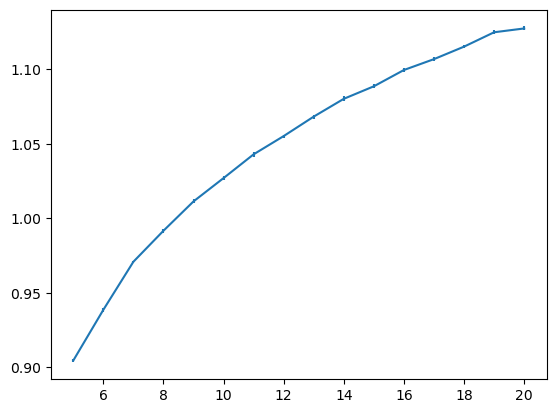

In [7]:
plt.errorbar(np.array(erchPercent), np.array(k_inf_erchPercent), np.array(kieP))

In [8]:
trisoPkFrac = range(30,60,2)
erchPercent = .1975

In [9]:
#      Fuel Kernel
fuel = openmc.Material(name="fuel")
fuel.set_density('g/cm3', rho_fuel)
fuel.add_nuclide('U235',erchPercent*U_form/(U_form+O_form))
fuel.add_nuclide('U238',((1-erchPercent)*U_form/(U_form+O_form)))
fuel.add_element('O', O_form/(U_form+O_form))
homogTrisoPart = openmc.Material.mix_materials([fuel, buffer, IPyC, SiC, OPyC], trisoPartVolFracs, 'vo')

In [10]:
#Enrichment Optimization
k_inf_tPkFrac = []
kitPF = []
for eki in trisoPkFrac:
    #B4
    homogTrisoPebCore = openmc.Material.mix_materials([homogTrisoPart,graphite], [eki/100, 1-eki/100], 'vo');
    homogTrisoPebble = openmc.Material.mix_materials([homogTrisoPebCore, graphite], pebbleVolFracs, 'vo');


    #B7
    homogCore = openmc.Material.mix_materials([homogTrisoPebble, He], [pebblePkFrac, 1-pebblePkFrac], 'vo')
    homogCore.add_s_alpha_beta('c_Graphite')
    materials = openmc.Materials()
    materials += [homogCore]
    materials.export_to_xml()
    
        #B8
    space = openmc.model.RightCircularCylinder(0, 1.25, .5, axis='z', boundaryType="vacuum")
    rxr = openmc.Cell(fill=homogCore, region=-space)
    universe = openmc.Universe(cells=[rxr])
    geometry = openmc.Geometry()
    geometry.root_universe = universe
    geometry.export_to_xml()
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue'
    settings.particles = 25000
    settings.batches = 45
    settings.inactive = 15
    settings.temperature={'method':'interpolation','range':(250,2500)}
    settings.export_to_xml()

    

    #B9
    num_threads_des = 36  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
    num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS
    
    openmc.run(threads = num_threads, output=True)
    sp = openmc.StatePoint('statepoint.45.h5')
    keff = sp.keff
    k_inf_tPkFrac.append(keff.n)
    kitPF.append(keff.s)
    sp.close()

TypeError: cannot unpack non-iterable int object

In [ ]:
plt.errorbar(np.array(trisoPkFrac), np.array(k_inf_tPkFrac),np.array(kitPF))